# Logistic Regression

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import sklearn.linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Simulierte Daten

In [2]:
observations_count = 1000
def generate_prices(number):
    return [np.round(np.random.uniform(1,20), decimals=1) for i in range(0, number)]

prices = generate_prices(observations_count)
competitors_count = 5
competitor_prices = np.matrix([generate_prices(observations_count) for i in range(0, competitors_count)])
ranks = [1 + len([1 for j in range(0, competitors_count) if competitor_prices[j,i] < prices[i]]) 
         for i in range(0, observations_count)]
sold = [np.maximum(0, np.round(np.random.uniform(0, 1-0.3*ranks[i]/(competitors_count+1)-0.05*prices[i]))) 
        for i in range(0, observations_count)]

## Regression

In [3]:
explanatory_count = 3
explanatory = np.matrix([[1 for j in range(0, observations_count)],
                        [ranks[j] for j in range(0, observations_count)],
                        [prices[j] - np.min([competitor_prices[k,j] for k in range(competitors_count)]) for j in range(observations_count)]])
logit = sm.Logit(sold, explanatory.transpose())
result = logit.fit()
beta = result.params
beta

Optimization terminated successfully.
         Current function value: 0.201391
         Iterations 9


array([-0.34664633, -0.74460809, -0.13129534])

In [4]:
result.aic

408.78240837292049

## Optimierung

In [5]:
def get_price_index(price):
    return price / 0.1 - 10

beta_demand = beta#[-0.650712, -0.489148, -0.174551]
competitor_prices = generate_prices(competitors_count)#[10.4, 12.5, 13.0, 5.4, 15.6]
prices_range = np.arange(1, 20.1, 0.1)
delta = 0.99
holding_cost_rate = 0.01
init_inventory = 10
steps = 100

data = []
for i in range(explanatory_count):
    if i == 0:
        data.append([1 for price in prices_range])
    elif i == 1:
        data.append([1 + len([1 for j in range(0, competitors_count) if competitor_prices[j] < price]) for price in prices_range])
    else:
        data.append([price - np.min([competitor_prices[j] for j in range(competitors_count)]) for price in prices_range])
explanatory = np.matrix(data)

data = []
for i in range(2):
    p = [np.exp(np.sum([beta_demand[m]*explanatory[m,get_price_index(price)] for m in range(explanatory_count)])) / (1 + np.exp(np.sum([beta_demand[m]*explanatory[m,get_price_index(price)] for m in range(explanatory_count)]))) for price in prices_range]
    if i == 1:
        data.append(p)
    else:
        data.append([1-j for j in p])
sale_prob = np.matrix(data)

values = np.empty(shape=(steps+1, init_inventory + 1))
for step in range(steps, -1, -1):
    for n in range(init_inventory + 1):
        if step == steps or n == 0:
            values[step, n] = 0
        else:
            values[step, n] = np.max([np.sum([sale_prob[i,get_price_index(price)]*(np.min([n,i]) * price - n * holding_cost_rate + delta * values[step+1, np.max([0, n-i])]) for i in range(2)]) for price in prices_range])

def opt_p(t):
    opt_prices = np.empty(init_inventory + 1)
    for n in range(init_inventory + 1):
        for price in prices_range:
            if np.sum([sale_prob[i,get_price_index(price)]*(np.min([n,i]) * price - n * holding_cost_rate + delta * values[t+1, np.max([0, n-i])]) for i in range(2)]) == values[t, n]:
                opt_prices[n] = price
                
    return opt_prices
                
opt_values = [values[0,n] for n in range(init_inventory + 1)]
opt_prices = opt_p(0)
opt_prices

array([ 20. ,  11.6,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         3.5,   3.5])

## Simulation

In [6]:
c_prices_time = np.empty(shape=(competitors_count, steps))
for c in range(competitors_count):
    c_prices_time[c,0] = competitor_prices[c]
inventory_time = np.empty(shape=(steps))
for t in range(steps):
    inventory_time[t] = init_inventory
o_prices_time = np.zeros(shape=(steps))
o_prices_time[0] = opt_prices[init_inventory]

for t in range(1,steps):
    if ((inventory_time[t] > 0) and (np.random.uniform(0,1) < sale_prob[1,get_price_index(o_prices_time[t-1])])):
        inventory_time[t] = np.max([0, inventory_time[t-1]-1])
    else:
        inventory_time[t] = inventory_time[t-1]
        
    #for c in range(competitors_count):
        #if (np.random.uniform(0,1) < 0.2):
            #c_prices_time[c,t]= np.round(c_prices_time[c,t-1] * np.random.uniform(0.8, 1.2), 1)
            
    if (inventory_time[t] > 0):
        opt_prices_n = opt_p(t)
        o_prices_time[t] = opt_prices_n[int(inventory_time[t])]
inventory_time

array([ 10.,   9.,   9.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   6.,   6.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   4.,   4.,   3.,
         3.,   3.,   3.,   3.,   3.,   2.,   2.,   2.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [7]:
o_prices_time

array([  3.5,   3.5,   3.5,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
        11.6,  11.6,  11.6,  11.6,  11.6,  11.6,  11.6,  11.6,  11.6,
        11.6,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,
         5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   5.8,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ])

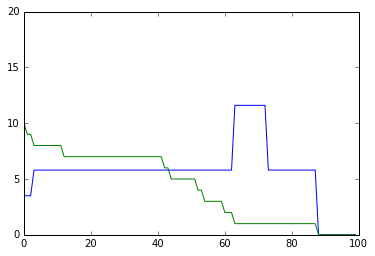

In [8]:
plt.plot(range(0,100),o_prices_time, range(0,100),inventory_time)
plt.axis([0,100,0,20])
plt.show()